
## Prepare Download dataset

Load credential from drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Make directory in local instance

zipping dataset

In [3]:
!cp -r /content/drive/Shareddrives/Capstone/Dataset/Dataset\ Fix/* /content/datasets

In [ ]:
!zip -rq dataset-fix-V2.zip /content/datasets/* 

# Start

Import necessary library

In [4]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

check gpu used

In [ ]:
!nvidia-smi

Thu May 19 12:56:02 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   51C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

mapping directory

In [ ]:
!cp -r /content/drive/Shareddrives/Capstone/dataset-fix.zip .

In [ ]:
!unzip -q /content/dataset-fix.zip

In [10]:
train_dir = "/content/datasets"
# train_dir = "/content/dataset/train"
test_dir = "/content/dataset/test"

Add global variable

In [11]:
NUM_BATCH = 128 #@param {type:"integer"}
NUM_EPOCH = 25 #@param {type:"integer"}
SIZE_IMG = (150, 150) #@param {type:"raw"}

Add Geneator and image augmentation

In [12]:
train_set = ImageDataGenerator(
    rescale = 1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    fill_mode = 'nearest',
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    # validation_split=0.2,
)

val_set = ImageDataGenerator(
    rescale = 1./255,
    # validation_split=0.2,
)

In [13]:
train_data = train_set.flow_from_directory(
    train_dir, 
    target_size =SIZE_IMG,
    shuffle = True,
    class_mode='categorical',
    # subset = 'training',
    batch_size=NUM_BATCH,
    seed = 128
)

# val_data = val_set.flow_from_directory(
#     train_dir, 
#     target_size = SIZE_IMG,
#     shuffle = True,
#     class_mode='categorical',
#     subset = 'validation',
#     batch_size=32,
#     seed = 128,
# )

Found 20378 images belonging to 32 classes.


In [ ]:
class_names = train_data.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_data.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

Load pre-trained model

In [15]:
DIM_IMG = SIZE_IMG + (3,)
# input_dim = tf.keras.Input(shape=DIM_IMG)
mobilenetv2_mod = tf.keras.applications.MobileNetV2(
                                                include_top=False,
                                                weights="imagenet",
                                                  # input_tensor=input_dim,
                                                  input_shape=DIM_IMG
                                                 )

9420800/9406464 [==============================] - 0s 0us/step


In [16]:
fine_tuning = True #@param {type:"boolean"}

if fine_tuning:
    mobilenetv2_mod.trainable = True    
else:
    mobilenetv2_mod.trainable = False

In [17]:
if fine_tuning:
    optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001)
else:
    optimizer = tf.keras.optimizers.Adam()

In [18]:
mobilenetv2_mod.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 75, 75, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 75, 75, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 75, 75, 32)   0           ['bn_Conv1[0][

In [ ]:
tf.keras.backend.clear_session()

Menyusun neural network layer

In [19]:
from keras.layers import Flatten, Dense, Dropout,GlobalMaxPooling2D
from keras import regularizers

model = tf.keras.models.Sequential([
                                    mobilenetv2_mod,
                                    GlobalMaxPooling2D(),
                                    Dense(128, activation='relu'),
                                    Dropout(0.3),
                                    Dense(32, activation='relu'),
                                    Dropout(0.2),
                                    Dense(16, activation='relu'),
                                    Dropout(0.2),
                                    Dense(32, activation='softmax')

])
model.compile(optimizer=optimizer, metrics=['accuracy'], loss=tf.keras.losses.CategoricalCrossentropy())

Membuat callback

In [20]:
class theCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('accuracy') > 0.95):
            print("\n Akurasi mencapai target, stop training")
            self.model.stop_training = True

# Instantiate a callback object
callbacks = theCallback()

Summary and compile

In [21]:
model.summary()
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                                 
 global_max_pooling2d (Globa  (None, 1280)             0         
 lMaxPooling2D)                                                  
                                                                 
 dense (Dense)               (None, 128)               163968    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 32)                4128      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0

In [22]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [24]:
hist = model.fit(train_data, 
                 epochs=25, 
                #  validation_data=val_data, 
                 steps_per_epoch=128, 
                #  callbacks=[callbacks]
                 )

Epoch 1/25
 19/128 [===>..........................] - ETA: 2:31 - loss: 0.8898 - accuracy: 0.7833

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


128/128 [==============================] - 178s 1s/step - loss: 0.8406 - accuracy: 0.7962
Epoch 2/25
128/128 [==============================] - 177s 1s/step - loss: 0.7496 - accuracy: 0.8155
Epoch 3/25
128/128 [==============================] - 183s 1s/step - loss: 0.6696 - accuracy: 0.8363
Epoch 4/25
128/128 [==============================] - 183s 1s/step - loss: 0.6465 - accuracy: 0.8420
Epoch 5/25
128/128 [==============================] - 179s 1s/step - loss: 0.5907 - accuracy: 0.8511
Epoch 6/25
128/128 [==============================] - 180s 1s/step - loss: 0.5646 - accuracy: 0.8610
Epoch 7/25
128/128 [==============================] - 179s 1s/step - loss: 0.5203 - accuracy: 0.8666
Epoch 8/25
128/128 [==============================] - 179s 1s/step - loss: 0.4850 - accuracy: 0.8768
Epoch 9/25
128/128 [==============================] - 178s 1s/step - loss: 0.4829 - accuracy: 0.8806
Epoch 10/25
128/128 [==============================] - 178s 1s/step - loss: 0.4757 - accuracy: 0.8827


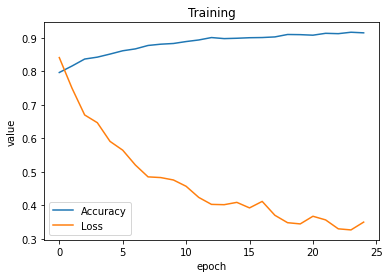

In [25]:
plt.plot(hist.history['accuracy'], label='Accuracy')
plt.plot(hist.history['loss'], label='Loss')
plt.title('Training')
plt.ylabel('value')
plt.xlabel('epoch')
plt.legend()
plt.show()
# summarize history for loss
# plt.plot(hist.history['val_accuracy'], label='Val Accuracy')
# plt.plot(hist.history['val_loss'], label='Val Los')
# plt.title('Validation')
# plt.ylabel('value')
# plt.xlabel('epoch')
# plt.legend()
# plt.show()

In [ ]:
import numpy as np
from google.colab import files
from keras.preprocessing import image

uploaded = files.upload()

for fn in uploaded.keys():
 
  # predicting images
  path = '/content/' + fn
  img = image.load_img(path, target_size=(150, 150))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)
  y_classes = classes.argmax(axis=-1)
  print(y_classes)
  # if classes[0]>0.5:
  #   print(fn + " is a dog")
  # else:
  #   print(fn + " is a cat")

Saving 1909753989.jpg to 1909753989 (1).jpg
[5]


In [ ]:
import numpy as np
from keras.preprocessing import image
np.loadtxt
classes = ['Fresh Apple','Fresh Banana','Fresh Orange','Rotten Apple','Rotten Banana','Rotten Orange']#creating the class labels
test_image = image.load_img('/content/dataset/test/rottenbanana/Screen Shot 2018-06-12 at 9.10.20 PM.png', target_size=(150,150))
test_image = image.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis = 0)
result = model.predict(test_image)
print(np.argmax(result))
result=result[0]
for i in range(6):
    if result[i] == 1.:
        break;
prediction = classes[i]
print(prediction)

0
Fresh Apple


In [26]:
RPS_SAVED_MODEL = "rps_saved_model"

In [27]:
tf.saved_model.save(model, RPS_SAVED_MODEL)

INFO:tensorflow:Assets written to: rps_saved_model/assets


INFO:tensorflow:Assets written to: rps_saved_model/assets


In [28]:
%%bash -s $RPS_SAVED_MODEL
saved_model_cli show --dir $1 --tag_set serve --signature_def serving_default

The given SavedModel SignatureDef contains the following input(s):
  inputs['mobilenetv2_1.00_224_input'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1, 150, 150, 3)
      name: serving_default_mobilenetv2_1.00_224_input:0
The given SavedModel SignatureDef contains the following output(s):
  outputs['dense_3'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1, 32)
      name: StatefulPartitionedCall:0
Method name is: tensorflow/serving/predict


In [29]:
loaded = tf.saved_model.load(RPS_SAVED_MODEL)

In [30]:
print(list(loaded.signatures.keys()))
infer = loaded.signatures["serving_default"]
print(infer.structured_input_signature)
print(infer.structured_outputs)

['serving_default']
((), {'mobilenetv2_1.00_224_input': TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name='mobilenetv2_1.00_224_input')})
{'dense_3': TensorSpec(shape=(None, 32), dtype=tf.float32, name='dense_3')}


In [31]:
converter = tf.lite.TFLiteConverter.from_saved_model(RPS_SAVED_MODEL)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()

In [32]:
tflite_model_file = 'converted_model.tflite'

with open(tflite_model_file, "wb") as f:
    f.write(tflite_model)

In [ ]:
from google.colab import files
files.download('/content/converted_model.tflite')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
!zip -r /content/rps_saved_model.zip /content/rps_saved_model
files.download('/content/rps_saved_model.zip')

  adding: content/rps_saved_model/ (stored 0%)
  adding: content/rps_saved_model/variables/ (stored 0%)
  adding: content/rps_saved_model/variables/variables.index (deflated 80%)
  adding: content/rps_saved_model/variables/variables.data-00000-of-00001 (deflated 7%)
  adding: content/rps_saved_model/saved_model.pb (deflated 91%)
  adding: content/rps_saved_model/assets/ (stored 0%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>